# Compare the segmentation labels to lab analysis and estimated coverage

In [1]:
import os
import os.path as osp
import glob

import pandas as pd
import numpy as np

import cv2
from tqdm import tqdm
from sklearn.metrics import r2_score

import matplotlib
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# uncomment to set the path to the full size images and labels on the Google Drive
#root = 'My Drive/ADIG_Labelled_Dataset/Test'
root = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-all-Team-Mussels/'

label_path = os.path.join(root, 'SegmentationClassPNG')
image_path = os.path.join(root, 'JPEGImages')

In [5]:
# Search for all png label files
all_images = glob.glob(osp.join(label_path, '*.png'))
print(len(all_images))
all_images.sort()

# show the first few files
all_images[:5]

109


['/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-all-Team-Mussels/SegmentationClassPNG/GLNI_1345-1_2017-08-17_image-2_crop.png',
 '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-all-Team-Mussels/SegmentationClassPNG/GLNI_1345-2_2017-08-17_image-2_crop.png',
 '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-all-Team-Mussels/SegmentationClassPNG/GLNI_1345-3_2017-08-17_image-2_crop.png',
 '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-all-Team-Mussels/SegmentationClassPNG/GLNI_1346-1_2017-08-17_image-1_crop.png',
 '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-all-Team-Mussels/SegmentationClassPNG/GLNI_1346-2_2017-08-17_image-1_crop.png']

In [4]:
# change me!
DATA_PATH = r'/scratch/gallowaa/cciw/Data'

imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)

analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')

analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')
data_df.columns

Index(['Dive Index', 'Quadrat', 'Live Coverage', 'Empty Coverage', 'Biomass',
       'Count', '16mm', '14mm', '12.5mm', '10mm', '8mm', '6.3mm', '4mm', '2mm',
       'Analysis Index', 'Cruise #', 'CSN', 'PSN', 'Date', 'Depth (m)',
       'Overall Coverage', 'Silt (%)', 'Clay (%)', 'Sand (%)', 'Gravel (%)',
       'Cobble (%)', 'Rock (%)', 'Bedrock (%)', 'Boulders (%)', 'Shale (%)',
       'Underlying Substrate Type', 'Underlying Substrate Depth (cm)'],
      dtype='object')

In [6]:
lab_targets = np.zeros((len(all_images), 3)) # 0 = biomass, 1 = count

for i in range(len(all_images)):
    key = all_images[i].split('/')[-1].split('.')[0].split('_image')[0]
    #print(key)
    guid = image_df[image_df['Name'].str.contains(key)]['Analysis Index'].astype('int64')
    #print(guid)
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    
    lab_targets[i, 0] = row['Count'].values
    lab_targets[i, 1] = row['Biomass'].values
    lab_targets[i, 2] = row['Live Coverage'].values
    #lab_targets[i, 3] = row['Overall Coverage'].values

# Read all masks from disk and sum up the mussel pixels

Takes 26 seconds to read 109 images from my local SSD

In [7]:
pix_ct = []
for i in tqdm(range(len(all_images))):
    im   = cv2.imread(all_images[i])
    _, cts = np.unique(im, return_counts=True) 
    try:
        pix_ct.append(cts[1] / cts.sum())
    except:
        pix_ct.append(0)
pix_ct_np = np.asarray(pix_ct)
pix_ct_np = pix_ct_np / pix_ct_np.max()

100%|██████████| 109/109 [00:26<00:00,  3.81it/s]


In [8]:
lab_targets[np.isnan(lab_targets)] = 0

for i in range(3):
    lab_targets[:, i] = lab_targets[:, i] / lab_targets[:, i].max()
#r_val = np.corrcoef(pix_ct_np, y)[1, 0]
x = pix_ct_np.copy()#[pix_ct_np < 0.01]
#y = y[pix_ct_np < 0.01]
#print(len(y))

#A = np.vstack([x, np.ones(len(x))]).T
#m, c = np.linalg.lstsq(A, y, rcond=None)[0]

# Simple criteria for finding outliers

In [9]:
mask_y = lab_targets[:, 2] > 0.4
mask_x = x < 0.2
upper_left = mask_x & mask_y

mask_y = lab_targets[:, 2] > 0.38
mask_x = x < 0.1
upper_left |= (mask_x & mask_y)

mask_y = lab_targets[:, 2] < 0.6
mask_x = x > 0.6
bottom_right = mask_x & mask_y

outliers = upper_left | bottom_right

inliers = np.invert(outliers)
print('Live Coverage R^2 value on %d inliers = %.4f' % (len(x[inliers]), r2_score(lab_targets[:, 2][inliers], x[inliers])))

Live Coverage R^2 value on 96 inliers = 0.6310


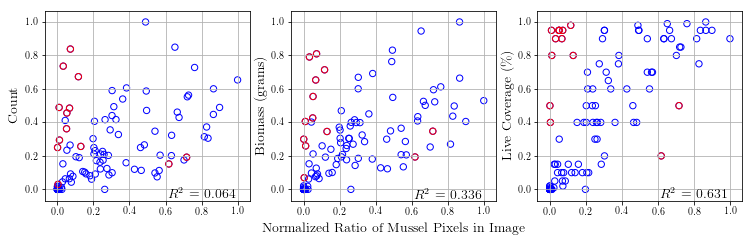

In [11]:
font = 14
COLOR_OUTLIERS = True  # Set to True to show outliers in red
fig, ax = plt.subplots(1, 3, figsize=(12.5, 3.5), sharex=True)

for i in range(3):
    
    ax[i].scatter(x, lab_targets[:, i], marker='o', s=40, facecolors='none', edgecolors='b')
    
    if i == 0:
        ax[i].set_ylabel('Count', fontsize=font)
    elif i == 1:
        ax[i].set_ylabel('Biomass (grams)', fontsize=font)
    elif i == 2:
        ax[i].set_ylabel('Live Coverage (\%)', fontsize=font)
    
    if COLOR_OUTLIERS:
        ax[i].scatter(x[outliers], lab_targets[:, i][outliers], 
                      marker='o', s=40, facecolors='none', edgecolors='r')    
        ax[i].annotate(r'$R^2$ = %.3f' % r2_score(lab_targets[:, i][inliers], x[inliers]), 
                       xy=(.6, 0.01), fontsize=font, xycoords='axes fraction')
    else:
        ax[i].annotate(r'$R^2$ = %.3f' % r2_score(lab_targets[:, i], x), 
                       xy=(.6, 0.01), fontsize=font, xycoords='axes fraction')
    ax[i].grid()
    #ax[i].set_ylim(0, 1.05)
    #ax[i].set_xlim(0, 1.05)

ax[1].set_xlabel('Normalized Ratio of Mussel Pixels in Image', fontsize=font)

fname = 'Train-all-109-annotate-outliers'
#plt.tight_layout()
#fig.savefig(fname + '.png')
#fig.savefig(fname + '.eps', format='eps')

# Examine outliers in more detail

In [12]:
for i, tf in enumerate(upper_left):
    if tf:
        key = all_images[i].split('/')[-1].split('.')[0].split('_image')[0]
        print('>', key)
        guid = image_df[image_df['Name'].str.contains(key)]['Analysis Index'].astype('int64')
        row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
        print('Count   %d' % row['Count'].values)
        print('Biomass %.2f' % row['Biomass'].values)
        print('LiveCov %d' % row['Live Coverage'].values)

> GLNI_2909-2_2017-08-21
Count   444
Biomass 129.03
LiveCov 80
> GLNI_2909-3_2017-08-21
Count   45
Biomass 34.62
LiveCov 40
> GLNI_3538-2_2018-07-03
Count   688
Biomass 275.93
LiveCov 95
> GLNI_3539-1_2018-06-20
Count   732
Biomass 324.93
LiveCov 90
> GLNI_3539-1_2018-07-03
Count   1015
Biomass 355.13
LiveCov 98
> GLNI_3539-2_2018-07-03
Count   1264
Biomass 402.66
LiveCov 95
> GLNI_3539-3_2018-07-03
Count   546
Biomass 212.19
LiveCov 95
> GLNI_3552-3_2017-08-30
Count   387
Biomass 171.91
LiveCov 80
> GLNI_3553-1_2017-08-30
Count   1110
Biomass 393.26
LiveCov 90
> GLNI_3783-1_2018-07-05
Count   377
Biomass 149.11
LiveCov 50
> GLNI_3788-1_2018-08-14
Count   738
Biomass 201.63
LiveCov 95
